In [1]:
import os
import pandas as pd
import torch
from torch.utils import data
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune

In [2]:
# get all the train and test files

train_files = []
test_files = []

for (dirpath, dirnames, filenames) in os.walk( 'iwls2020-lsml-contest/benchmarks/train/' ):
    for file in filenames:
      train_files.append(os.path.join(dirpath,file) )
for (dirpath, dirnames, filenames) in os.walk( 'iwls2020-lsml-contest/benchmarks/vaidation/' ):
    for file in filenames:
      train_files.append(os.path.join(dirpath,file) )
for (dirpath, dirnames, filenames) in os.walk( 'iwls2020-lsml-contest/benchmarks/test/' ):
    for file in filenames:
      test_files.append(os.path.join(dirpath,file) )

train_files.sort()
test_files.sort()

In [25]:
# Experiment 1a - 2 layer NN with pruning

def split(word): 
    return [char for char in word] 

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

def accuracy(output,labels):
  output = output >=0.5
  acc = torch.sum(output==labels)/len(labels)
  return acc

def get_tensors_from_example_files(train_file, test_file):
  ''' get features and label tensors from training and test files'''
  file_train_data = open(train_file, 'r')
  file_train_data = file_train_data.readlines()

  file_test_data = open(test_file, 'r')
  file_test_data = file_test_data.readlines()

  # preprocess files to separate inputs and outputs
  x_train = []
  y_train = []
  for line in file_train_data:
    if not (line.startswith('.')):
      x_train.append( line[:line.index(' ')] )
      y_train.append( line[ line.index(' ')+1:line.index(' ')+2 ] ) 

  x_test = []
  y_test = []
  for line in file_test_data:
    if not (line.startswith('.')):
      x_test.append( line[:line.index(' ')] )
      y_test.append( line[ line.index(' ')+1:line.index(' ')+2 ] ) 

  # convert data to tensors
  for i,input in enumerate(x_train):
    x_train[i] = split(input)
    # convert each character to integer
    for j,bit in enumerate(x_train[i]):
        x_train[i][j] = int(bit)
  features_train = torch.FloatTensor(x_train)
  y_train = [int(i) for i in y_train]
  labels_train = torch.FloatTensor(y_train)

  for i,input in enumerate(x_test):
    x_test[i] = split(input)
    # convert each character to integer
    for j,bit in enumerate(x_test[i]):
        x_test[i][j] = int(bit)
  features_test = torch.FloatTensor(x_test)
  y_test = [int(i) for i in y_test]
  labels_test = torch.FloatTensor(y_test)

  return features_train, labels_train, features_test, labels_test

def get_dataloaders(features_train, labels_train, features_test, labels_test):
  ''' form iterable dataloaders for features and labels'''
  batch_size = 10
  train_data_iter = load_array((features_train, labels_train), batch_size)
  test_data_iter = load_array((features_train, labels_train), batch_size)
  return train_data_iter, test_data_iter

def define_neural_net(input_size):

  net = BinaryClassification(input_size)
  net.to(device)
  Loss = nn.BCELoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

  return net, Loss, optimizer

def train_truth_table( net, Loss, optimizer, train_data_iter, num_epochs, features_train, labels_train ):

  net.train()
  for epoch in range(num_epochs):
      for X, y in train_data_iter:
          X = X.cuda()
          y = y.cuda()
          output = net(X)
          l = Loss(output, y.reshape(-1,1) )
          optimizer.zero_grad()
          l.backward()
          optimizer.step()
#       if (epoch%10==0):
#         acc = accuracy(net(features_train.cuda()).cpu(), labels_train.reshape(-1,1))
#         l = Loss(net(features_train.cuda()).cpu(), labels_train.reshape(-1,1))
  
  return net

def test_net( net, test_data_iter):
  acc = 0
  net.eval()
  with torch.no_grad():
    for X,y in test_data_iter:
      X = X.cuda()
      output = net(X)
      acc = acc + accuracy(output.cpu(), y.reshape(-1,1))
    acc = acc/ len(test_data_iter)
  return acc

# get_lut_y
def get_lut_y(input_size,w,b):
    lut_y = np.zeros( (pow(2,input_size)), dtype=bool )
    input_vector = np.zeros( (input_size) )
    for idx in range ( pow(2,input_size) ):
        #get entry in LUT
        out = input_vector.dot(w) + b
        lut_y[idx] = 1/(1 + np.exp(-out)) >=0.5
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0   
    return lut_y

# prune
def prune_model(input_size, net):
    remain_after_pruning = 8 + ( (10-8)/(768-10) )*(input_size-10)
    pruning_ratio = (input_size-remain_after_pruning)/input_size

    # prune first layer
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.3
    )
    prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 10
    )
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.4
    )

    # prune second layer
    prune.ln_structured(
       net.linear2, 'weight', amount=0.3, dim=1, n='fro'
    )
    # after pruning
    prune.remove(net.linear1, 'weight') # makes pruning permanent
    prune.remove(net.linear2, 'weight') # makes pruning permanent

    return net

def get_aig_size(net):
    # get list of neurons in NN
    neurons = [] # each element is a neuron with a weight vector and a bias scalar
    weights = [] # each element is the weight matrix of a layer
    biases  = [] # each element contains biases for that layer
    for name, param in net.named_parameters():
        if '.weight'in name:
            weights.append( param.detach().cpu().numpy() )
        if '.bias' in name:
            biases.append( param.detach().cpu().numpy() )

    weights.reverse()
    biases.reverse()
    ignore_neurons = [] # element in list: (i,j) neuron j in layer i
    for i,layer_weights in enumerate(weights): # i = layer (starting from highest)

        # check which neurons in lower layer can be ignored
        for k in range( len(layer_weights[0]) ):
            if( len( np.nonzero(layer_weights[:,k])[0] )==0 ):
                ignore_neurons.append( (i+1,k) )

        for j,weight_vector in enumerate(layer_weights): # j = neuron in layer i
            if not (i,j) in ignore_neurons:
                neurons.append((weight_vector,biases[i][j]))

    # get size of aig  
#     print("getting size of aig")
    size_aig = 0

    for neuron in neurons: 
        '''form LUT for each neuron'''
        w = neuron[0]
        b = neuron[1]
        w = w[w.nonzero()]
        input_size = len(w)
        # get the LUT
        lut_y = get_lut_y(input_size, w, b)

        '''create text for verilog file representing LUT'''
        n=input_size
#         print(input_size)
        file_string ='module lut_verilog(\ninput wire['+str(input_size-1)+':0] in,\noutput reg out\n);\n\nalways@(in) begin\ncase(in)\n'
        input_vector = np.zeros( (input_size) )
        for idx in range ( pow(2,input_size) ):
            # add to file string
            file_string += str(input_size)+'\'b'+''.join(str(int(e)) for e in input_vector)+' : out = '+str(int(lut_y[idx]))+';\n'
            # increment input vector
            for i in range(len(input_vector)-1, -1, -1):
                if input_vector[i] == 0:
                    input_vector[i] = 1
                    break
                input_vector[i] = 0
        file_string+='endcase\nend\nendmodule\n'

        '''write to verilog file'''
        f = open("lut_verilog.v", "w")
        f.write(file_string)
        f.close()

        '''produce the .aig file using yosys script'''
        cmd = "yosys neuron_to_aig_size.ys >/dev/null 2>&1"
        os.system(cmd)

        '''get the number of and gates in aig and add to the running sum'''
        f = open("lut_verilog.aig", "r")
        line = f.readline()
        size_aig = size_aig + int(line.split(' ')[5].split('\n')[0])
        #     print("size: ", line.split(' ')[5].split('\n')[0] )
        #     print("running sum: ",size_aig)
    return size_aig

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
# Run experiment 1a

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# prune the model
# get aig size
# test the model, note the accuracy

results = []
for i in range(len(train_files)):
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  print("\nworking on truth table: ", ex_id)
  print("input size = ", input_size)

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )

  print("pruning")
  prune_model(input_size, net)
  
  print("getting size of aig")
  # get size of aig
  size_aig = get_aig_size(net) 
  print("size of aig: ", size_aig)

  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
#   if (i%5==0):
  print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item(), size_aig )
  results.append( result )


working on truth table:  ex00
input size =  32
pruning
getting size of aig
size of aig:  746
test accuracy achieved:  0.5146874785423279

working on truth table:  ex01
input size =  32
pruning
getting size of aig
size of aig:  833
test accuracy achieved:  0.933906078338623

working on truth table:  ex02
input size =  64
pruning
getting size of aig
size of aig:  1834
test accuracy achieved:  0.5320314168930054

working on truth table:  ex03
input size =  64
pruning
getting size of aig
size of aig:  1811
test accuracy achieved:  0.899686336517334

working on truth table:  ex04
input size =  128
pruning
getting size of aig
size of aig:  4196
test accuracy achieved:  0.5065627694129944

working on truth table:  ex05
input size =  128
pruning
getting size of aig
size of aig:  1480
test accuracy achieved:  0.9406243562698364

working on truth table:  ex06
input size =  256
pruning
getting size of aig
size of aig:  17706
test accuracy achieved:  0.5460940599441528

working on truth table:  e

In [50]:
print(results)

[('ex00', 32, 0.5146874785423279, 746), ('ex01', 32, 0.933906078338623, 833), ('ex02', 64, 0.5320314168930054, 1834), ('ex03', 64, 0.899686336517334, 1811), ('ex04', 128, 0.5065627694129944, 4196), ('ex05', 128, 0.9406243562698364, 1480), ('ex06', 256, 0.5460940599441528, 17706), ('ex07', 256, 0.968593418598175, 3359), ('ex08', 512, 0.5090627074241638, 180419), ('ex09', 512, 0.9509369134902954, 44771), ('ex10', 32, 0.798279881477356, 1339), ('ex11', 64, 0.7360932230949402, 1464), ('ex12', 128, 0.6610943675041199, 2468), ('ex13', 256, 0.645156741142273, 3501), ('ex14', 512, 0.6582816243171692, 28840), ('ex15', 32, 0.8281232714653015, 1379), ('ex16', 64, 0.8364049792289734, 3465), ('ex17', 128, 0.7753114104270935, 3559), ('ex18', 256, 0.6401569843292236, 7443), ('ex19', 512, 0.8251544237136841, 29426), ('ex20', 16, 0.5125001668930054, 468), ('ex21', 16, 0.5309373140335083, 560), ('ex22', 32, 0.49859386682510376, 479), ('ex23', 32, 0.5295314788818359, 510), ('ex24', 64, 0.5250004529953003

In [51]:
results = [('ex00', 32, 0.5146874785423279, 746), ('ex01', 32, 0.933906078338623, 833), ('ex02', 64, 0.5320314168930054, 1834), ('ex03', 64, 0.899686336517334, 1811), ('ex04', 128, 0.5065627694129944, 4196), ('ex05', 128, 0.9406243562698364, 1480), ('ex06', 256, 0.5460940599441528, 17706), ('ex07', 256, 0.968593418598175, 3359), ('ex08', 512, 0.5090627074241638, 180419), ('ex09', 512, 0.9509369134902954, 44771), ('ex10', 32, 0.798279881477356, 1339), ('ex11', 64, 0.7360932230949402, 1464), ('ex12', 128, 0.6610943675041199, 2468), ('ex13', 256, 0.645156741142273, 3501), ('ex14', 512, 0.6582816243171692, 28840), ('ex15', 32, 0.8281232714653015, 1379), ('ex16', 64, 0.8364049792289734, 3465), ('ex17', 128, 0.7753114104270935, 3559), ('ex18', 256, 0.6401569843292236, 7443), ('ex19', 512, 0.8251544237136841, 29426), ('ex20', 16, 0.5125001668930054, 468), ('ex21', 16, 0.5309373140335083, 560), ('ex22', 32, 0.49859386682510376, 479), ('ex23', 32, 0.5295314788818359, 510), ('ex24', 64, 0.5250004529953003, 1075), ('ex25', 64, 0.5065627098083496, 866), ('ex26', 128, 0.53578120470047, 3512), ('ex27', 128, 0.4903126657009125, 4252), ('ex28', 256, 0.5429688692092896, 15794), ('ex29', 256, 0.5259374976158142, 13754), ('ex30', 20, 0.9374991655349731, 683), ('ex31', 40, 0.9679688215255737, 1385), ('ex32', 60, 0.9346866607666016, 805), ('ex33', 80, 0.9857813715934753, 2434), ('ex34', 100, 0.9687497019767761, 2041), ('ex35', 120, 0.970624566078186, 1770), ('ex36', 140, 0.9823437929153442, 2002), ('ex37', 160, 0.9701560735702515, 3013), ('ex38', 180, 0.9435935020446777, 2881), ('ex39', 200, 0.9718747138977051, 2237), ('ex40', 16, 0.5432815551757812, 380), ('ex41', 10, 0.6075006127357483, 754), ('ex42', 32, 0.528906524181366, 787), ('ex43', 18, 0.5210939645767212, 639), ('ex44', 64, 0.5295316576957703, 1524), ('ex45', 34, 0.5214067697525024, 791), ('ex46', 128, 0.5337501764297485, 2131), ('ex47', 66, 0.513750433921814, 856), ('ex48', 256, 0.528906524181366, 12667), ('ex49', 130, 0.5198441743850708, 2071), ('ex50', 19, 0.7932802438735962, 988), ('ex51', 44, 0.5106251239776611, 2100), ('ex52', 59, 0.595625638961792, 1484), ('ex53', 45, 0.7521874904632568, 1219), ('ex54', 48, 0.7521868944168091, 1148), ('ex55', 42, 0.8315609693527222, 504), ('ex56', 83, 0.6192189455032349, 2029), ('ex57', 24, 0.9676566123962402, 429), ('ex58', 80, 0.8768739700317383, 1542), ('ex59', 394, 0.6692193150520325, 12793), ('ex60', 43, 0.7682810425758362, 1816), ('ex61', 37, 0.7579684853553772, 989), ('ex62', 52, 0.8782796859741211, 1574), ('ex63', 38, 0.8879672288894653, 1135), ('ex64', 47, 0.9506245851516724, 1054), ('ex65', 19, 0.7746871709823608, 1245), ('ex66', 47, 0.7760927677154541, 1247), ('ex67', 46, 0.7404682636260986, 1206), ('ex68', 33, 0.9443745613098145, 1058), ('ex69', 16, 0.9343745112419128, 524), ('ex70', 23, 0.9335931539535522, 872), ('ex71', 23, 0.9189052581787109, 717), ('ex72', 35, 0.8815611600875854, 625), ('ex73', 16, 0.6075009107589722, 1103), ('ex74', 16, 0.5117185711860657, 376), ('ex75', 16, 0.3946872651576996, 263), ('ex76', 16, 0.793123722076416, 1013), ('ex77', 16, 0.7931236028671265, 853), ('ex78', 16, 0.6417192816734314, 479), ('ex79', 16, 0.7931238412857056, 981), ('ex80', 196, 0.5768752098083496, 3315), ('ex81', 196, 0.7396873235702515, 4352), ('ex82', 196, 0.8343733549118042, 6597), ('ex83', 196, 0.8339049220085144, 4939), ('ex84', 196, 0.7879678010940552, 13012), ('ex85', 196, 0.5296874046325684, 7323), ('ex86', 196, 0.5348438024520874, 8226), ('ex87', 196, 0.7910926938056946, 3942), ('ex88', 196, 0.8290611505508423, 12914), ('ex89', 196, 0.7828117609024048, 10836), ('ex90', 768, 0.5201565027236938, 375187), ('ex91', 768, 0.5110938549041748, 476028), ('ex92', 768, 0.5476566553115845, 474636), ('ex93', 768, 0.5317188501358032, 661743), ('ex94', 768, 0.553750216960907, 1017241), ('ex95', 768, 0.5987504720687866, 550106), ('ex96', 768, 0.5248436331748962, 148062), ('ex97', 768, 0.5040621757507324, 458732), ('ex98', 768, 0.4987497329711914, 396343), ('ex99', 768, 0.5329688787460327, 209708)]

In [52]:
# Analysis

ids = np.asarray([res[0] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 100 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 100 benchmarks=  70.50028610229492  %
26 networks exceeded size constraint:
['ex06' 'ex08' 'ex09' 'ex14' 'ex18' 'ex19' 'ex28' 'ex29' 'ex48' 'ex59'
 'ex82' 'ex84' 'ex85' 'ex86' 'ex88' 'ex89' 'ex90' 'ex91' 'ex92' 'ex93'
 'ex94' 'ex95' 'ex96' 'ex97' 'ex98' 'ex99']
overall accuracy across benchmarks under size constraints=  73.62306883206239  %


In [29]:
f = open("results_exp1a.txt","w")
f.write(str(results))
f.close()

In [26]:
# Experiment 2a - 3 layer NN with pruning

#Net
class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size, input_size//2)
    self.linear2 = nn.Linear(input_size//2, input_size//4)
    self.linear3 = nn.Linear(input_size//4,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    x = torch.sigmoid( self.linear3(x) )
    return x

# prune
def prune_model(input_size, net):
    remain_after_pruning = 8 + ( (10-8)/(768-10) )*(input_size-10)
    pruning_ratio = (input_size-remain_after_pruning)/input_size

    # prune first layer
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.3
    )
    prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 10
    )
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.4
    )
    
    # prune second layer
    prune.l1_unstructured(
       net.linear2, 'weight', amount=0.3
    )
    prune.ln_structured(
       net.linear2, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 10
    )
    prune.l1_unstructured(
       net.linear2, 'weight', amount=0.4
    )

    input_layer3 = input_size//4
    # map [768/4 ..... 2 ] to [12 ... 2]
    remain_after_pruning = 2 + ( (12-2)/((768//4)-2) )*(input_layer3-2)
    pruning_ratio_layer3 = (input_layer3-remain_after_pruning)/input_layer3
    
    # prune third layer
    prune.ln_structured(
       net.linear3, 'weight', amount=pruning_ratio_layer3, dim=1, n='fro'
    )
    # after pruning
    prune.remove(net.linear1, 'weight') # makes pruning permanent
    prune.remove(net.linear2, 'weight') # makes pruning permanent
    prune.remove(net.linear3, 'weight') # makes pruning permanent

    return net

In [27]:
# Run experiment 2a

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# prune the model
# get aig size
# test the model, note the accuracy

results = []
for i in range(len(train_files)):
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  print("\nworking on truth table: ", ex_id)
  print("input size = ", input_size)

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )

  print("pruning")
  prune_model(input_size, net)
  
  print("getting size of aig")
  # get size of aig
  size_aig = get_aig_size(net) 
  print("size of aig: ", size_aig)

  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
#   if (i%5==0):
  print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item(), size_aig )
  results.append( result )


working on truth table:  ex00
input size =  32
pruning
getting size of aig
size of aig:  424
test accuracy achieved:  0.5079687237739563

working on truth table:  ex01
input size =  32
pruning
getting size of aig
size of aig:  807
test accuracy achieved:  0.937498927116394

working on truth table:  ex02
input size =  64
pruning
getting size of aig
size of aig:  213
test accuracy achieved:  0.5070310831069946

working on truth table:  ex03
input size =  64
pruning
getting size of aig
size of aig:  932
test accuracy achieved:  0.7887492775917053

working on truth table:  ex04
input size =  128
pruning
getting size of aig
size of aig:  173
test accuracy achieved:  0.5089061260223389

working on truth table:  ex05
input size =  128
pruning
getting size of aig
size of aig:  1288
test accuracy achieved:  0.8073423504829407

working on truth table:  ex06
input size =  256
pruning
getting size of aig
size of aig:  592
test accuracy achieved:  0.4951561987400055

working on truth table:  ex07


In [28]:
print(results)

[('ex00', 32, 0.5079687237739563, 424), ('ex01', 32, 0.937498927116394, 807), ('ex02', 64, 0.5070310831069946, 213), ('ex03', 64, 0.7887492775917053, 932), ('ex04', 128, 0.5089061260223389, 173), ('ex05', 128, 0.8073423504829407, 1288), ('ex06', 256, 0.4951561987400055, 592), ('ex07', 256, 0.6717190146446228, 2201), ('ex08', 512, 0.5, 2503), ('ex09', 512, 0.5049999952316284, 3809), ('ex10', 32, 0.6587504744529724, 1317), ('ex11', 64, 0.6632817983627319, 1430), ('ex12', 128, 0.6528134942054749, 983), ('ex13', 256, 0.6445316076278687, 1476), ('ex14', 512, 0.6585946679115295, 5021), ('ex15', 32, 0.4946872591972351, 892), ('ex16', 64, 0.7410939335823059, 1998), ('ex17', 128, 0.49406275153160095, 2098), ('ex18', 256, 0.4899999499320984, 1954), ('ex19', 512, 0.49734362959861755, 3527), ('ex20', 16, 0.4968748092651367, 313), ('ex21', 16, 0.5075001120567322, 186), ('ex22', 32, 0.5014060735702515, 33), ('ex23', 32, 0.5015626549720764, 134), ('ex24', 64, 0.503437340259552, 144), ('ex25', 64, 0.5

In [29]:
f = open("results_exp2a.txt","w")
f.write(str(results))
f.close()

In [54]:
results = [('ex00', 32, 0.5079687237739563, 424), ('ex01', 32, 0.937498927116394, 807), ('ex02', 64, 0.5070310831069946, 213), ('ex03', 64, 0.7887492775917053, 932), ('ex04', 128, 0.5089061260223389, 173), ('ex05', 128, 0.8073423504829407, 1288), ('ex06', 256, 0.4951561987400055, 592), ('ex07', 256, 0.6717190146446228, 2201), ('ex08', 512, 0.5, 2503), ('ex09', 512, 0.5049999952316284, 3809), ('ex10', 32, 0.6587504744529724, 1317), ('ex11', 64, 0.6632817983627319, 1430), ('ex12', 128, 0.6528134942054749, 983), ('ex13', 256, 0.6445316076278687, 1476), ('ex14', 512, 0.6585946679115295, 5021), ('ex15', 32, 0.4946872591972351, 892), ('ex16', 64, 0.7410939335823059, 1998), ('ex17', 128, 0.49406275153160095, 2098), ('ex18', 256, 0.4899999499320984, 1954), ('ex19', 512, 0.49734362959861755, 3527), ('ex20', 16, 0.4968748092651367, 313), ('ex21', 16, 0.5075001120567322, 186), ('ex22', 32, 0.5014060735702515, 33), ('ex23', 32, 0.5015626549720764, 134), ('ex24', 64, 0.503437340259552, 144), ('ex25', 64, 0.5010939836502075, 157), ('ex26', 128, 0.4996875822544098, 149), ('ex27', 128, 0.5101560354232788, 198), ('ex28', 256, 0.5046876072883606, 678), ('ex29', 256, 0.5078125, 662), ('ex30', 20, 0.9414055943489075, 419), ('ex31', 40, 0.9531248211860657, 1314), ('ex32', 60, 0.7974989414215088, 872), ('ex33', 80, 0.7918737530708313, 1333), ('ex34', 100, 0.504843533039093, 1376), ('ex35', 120, 0.5017188787460327, 876), ('ex36', 140, 0.7356252074241638, 1302), ('ex37', 160, 0.8126554489135742, 1095), ('ex38', 180, 0.645469069480896, 1245), ('ex39', 200, 0.6748441457748413, 1720), ('ex40', 16, 0.5021877884864807, 66), ('ex41', 10, 0.5821877717971802, 85), ('ex42', 32, 0.5007809400558472, 174), ('ex43', 18, 0.5023436546325684, 226), ('ex44', 64, 0.4989061951637268, 242), ('ex45', 34, 0.4895310401916504, 148), ('ex46', 128, 0.505937397480011, 72), ('ex47', 66, 0.5007813572883606, 287), ('ex48', 256, 0.4834372103214264, 886), ('ex49', 130, 0.4957813620567322, 391), ('ex50', 19, 0.5525004863739014, 152), ('ex51', 44, 0.5146876573562622, 418), ('ex52', 59, 0.5998443961143494, 452), ('ex53', 45, 0.7521870136260986, 434), ('ex54', 48, 0.7574991583824158, 632), ('ex55', 42, 0.5773441791534424, 436), ('ex56', 83, 0.910936713218689, 1289), ('ex57', 24, 0.18484333157539368, 202), ('ex58', 80, 0.7604680061340332, 728), ('ex59', 394, 0.5225000977516174, 2377), ('ex60', 43, 0.680469274520874, 950), ('ex61', 37, 0.7514058351516724, 586), ('ex62', 52, 0.851248562335968, 1096), ('ex63', 38, 0.8873423337936401, 684), ('ex64', 47, 0.8873424530029297, 491), ('ex65', 19, 0.7584373950958252, 435), ('ex66', 47, 0.7898426651954651, 731), ('ex67', 46, 0.7809368371963501, 797), ('ex68', 33, 0.8792176246643066, 647), ('ex69', 16, 0.9460933804512024, 371), ('ex70', 23, 0.8728114366531372, 375), ('ex71', 23, 0.8998425602912903, 598), ('ex72', 35, 0.24999991059303284, 513), ('ex73', 16, 0.6410942673683167, 207), ('ex74', 16, 0.5117186903953552, 45), ('ex75', 16, 0.3946872353553772, 71), ('ex76', 16, 0.7931239604949951, 149), ('ex77', 16, 0.793123722076416, 134), ('ex78', 16, 0.6417196989059448, 44), ('ex79', 16, 0.7931238412857056, 139), ('ex80', 196, 0.4875001013278961, 1876), ('ex81', 196, 0.4912498891353607, 1417), ('ex82', 196, 0.47921842336654663, 1409), ('ex83', 196, 0.513593852519989, 1165), ('ex84', 196, 0.47562485933303833, 2064), ('ex85', 196, 0.49359384179115295, 1777), ('ex86', 196, 0.524374783039093, 1825), ('ex87', 196, 0.4987502098083496, 1135), ('ex88', 196, 0.4817185401916504, 1907), ('ex89', 196, 0.4884374141693115, 1726), ('ex90', 768, 0.5035936236381531, 6977), ('ex91', 768, 0.5189059972763062, 6811), ('ex92', 768, 0.5034374594688416, 11745), ('ex93', 768, 0.5064063668251038, 8845), ('ex94', 768, 0.5104693174362183, 7061), ('ex95', 768, 0.49312496185302734, 8751), ('ex96', 768, 0.5021876692771912, 10091), ('ex97', 768, 0.506250262260437, 9984), ('ex98', 768, 0.4985935688018799, 8717), ('ex99', 768, 0.5035935640335083, 8203)]

In [58]:
# Analysis

ids = np.asarray([res[0] for res in results])
input_sizes = np.asarray([res[1] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 100 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 100 benchmarks=  60.59670150279999  %
11 networks exceeded size constraint:
['ex14' 'ex90' 'ex91' 'ex92' 'ex93' 'ex94' 'ex95' 'ex96' 'ex97' 'ex98'
 'ex99']
overall accuracy across benchmarks under size constraints=  61.67589218428965  %


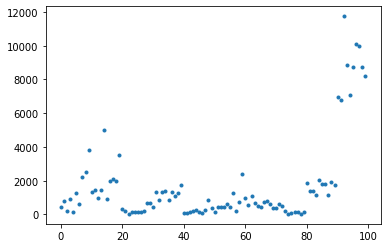

In [57]:
plt.plot(aig_sizes, '.')

In [59]:
print(input_sizes)

[ 32  32  64  64 128 128 256 256 512 512  32  64 128 256 512  32  64 128
 256 512  16  16  32  32  64  64 128 128 256 256  20  40  60  80 100 120
 140 160 180 200  16  10  32  18  64  34 128  66 256 130  19  44  59  45
  48  42  83  24  80 394  43  37  52  38  47  19  47  46  33  16  23  23
  35  16  16  16  16  16  16  16 196 196 196 196 196 196 196 196 196 196
 768 768 768 768 768 768 768 768 768 768]


In [61]:
print(input_sizes[size_exceeded])

[512 768 768 768 768 768 768 768 768 768 768]


insight: cater the pruning to sizes 512 and lower and see improvements in accuracy?

In [68]:
# Experiment 2b - 3 layer NN with pruning (ignoring size of circuit > 768)

#Net
class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size, input_size//2)
    self.linear2 = nn.Linear(input_size//2, input_size//4)
    self.linear3 = nn.Linear(input_size//4,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    x = torch.sigmoid( self.linear3(x) )
    return x

# prune
def prune_model(input_size, net):
    
    # map [512 ..... 10 ] to [12 ... 8]
    remain_after_pruning = 8 + ( (12-8)/(512-10) )*(input_size-10)
    pruning_ratio = (input_size-remain_after_pruning)/input_size
    # prune first layer
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.1
    )
    prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 12
    )
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.2
    )
    
    input_layer2 = input_size//2
    # map [256 ..... 5 ] to [12 ... 5]
    remain_after_pruning = 5 + ( (12-5)/(256-5) )*(input_layer2-5)
    pruning_ratio = (input_layer2-remain_after_pruning)/input_layer2
    # prune second layer
    prune.l1_unstructured(
       net.linear2, 'weight', amount=0.1
    )
    prune.ln_structured(
       net.linear2, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 12
    )
    prune.l1_unstructured(
       net.linear2, 'weight', amount=0.2
    )

    input_layer3 = input_size//4
    # map [128 ..... 2 ] to [12 ... 2]
    remain_after_pruning = 2 + ( (12-2)/(128-2) )*(input_layer3-2)
    pruning_ratio_layer3 = (input_layer3-remain_after_pruning)/input_layer3
    # prune third layer
    prune.ln_structured(
       net.linear3, 'weight', amount=pruning_ratio_layer3, dim=1, n='fro'
    )
    
    # after pruning
    prune.remove(net.linear1, 'weight') # makes pruning permanent
    prune.remove(net.linear2, 'weight') # makes pruning permanent
    prune.remove(net.linear3, 'weight') # makes pruning permanent

    return net

In [69]:
# Run experiment 2b

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# prune the model
# get aig size
# test the model, note the accuracy

results = []
for i in range(len(train_files)):
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  print("\nworking on truth table: ", ex_id)
  print("input size = ", input_size)

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )

  print("pruning")
  net = prune_model(input_size, net)
  
  print("getting size of aig")
  # get size of aig
  size_aig = get_aig_size(net) 
  print("size of aig: ", size_aig)

  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
#   if (i%5==0):
  print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item(), size_aig )
  results.append( result )


working on truth table:  ex00
input size =  32
pruning
getting size of aig
size of aig:  787
test accuracy achieved:  0.5079687237739563

working on truth table:  ex01
input size =  32
pruning
getting size of aig
size of aig:  1704
test accuracy achieved:  0.9060929417610168

working on truth table:  ex02
input size =  64
pruning
getting size of aig
size of aig:  1099
test accuracy achieved:  0.4929686188697815

working on truth table:  ex03
input size =  64
pruning
getting size of aig
size of aig:  2309
test accuracy achieved:  0.9645308256149292

working on truth table:  ex04
input size =  128
pruning
getting size of aig
size of aig:  2447
test accuracy achieved:  0.5089065432548523

working on truth table:  ex05
input size =  128
pruning
getting size of aig
size of aig:  5616
test accuracy achieved:  0.8262486457824707

working on truth table:  ex06
input size =  256
pruning
getting size of aig
size of aig:  5931
test accuracy achieved:  0.5048436522483826

working on truth table: 

KeyboardInterrupt: 

In [70]:
print(results)

[('ex00', 32, 0.5079687237739563, 787), ('ex01', 32, 0.9060929417610168, 1704), ('ex02', 64, 0.4929686188697815, 1099), ('ex03', 64, 0.9645308256149292, 2309), ('ex04', 128, 0.5089065432548523, 2447), ('ex05', 128, 0.8262486457824707, 5616), ('ex06', 256, 0.5048436522483826, 5931), ('ex07', 256, 0.702968955039978, 11249), ('ex08', 512, 0.49999985098838806, 73272), ('ex09', 512, 0.5131253004074097, 107942), ('ex10', 32, 0.7264061570167542, 1312), ('ex11', 64, 0.6632816195487976, 2297), ('ex12', 128, 0.6467191576957703, 4619), ('ex13', 256, 0.6445317268371582, 10718), ('ex14', 512, 0.6585944890975952, 145821), ('ex15', 32, 0.5053125619888306, 1829), ('ex16', 64, 0.5009377002716064, 2357), ('ex17', 128, 0.835623562335968, 6745), ('ex18', 256, 0.4900001585483551, 16492), ('ex19', 512, 0.502656102180481, 107537), ('ex20', 16, 0.5031251907348633, 546), ('ex21', 16, 0.4924996793270111, 476), ('ex22', 32, 0.5014063119888306, 668), ('ex23', 32, 0.4984373450279236, 934), ('ex24', 64, 0.503437399

In [71]:
f = open("results_exp2b.txt","w")
f.write(str(results))
f.close()

In [73]:
# Analysis

ids = np.asarray([res[0] for res in results])
input_sizes = np.asarray([res[1] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 91 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 91 benchmarks=  63.01113213156606  %
29 networks exceeded size constraint:
['ex05' 'ex06' 'ex07' 'ex08' 'ex09' 'ex13' 'ex14' 'ex17' 'ex18' 'ex19'
 'ex28' 'ex29' 'ex35' 'ex36' 'ex37' 'ex38' 'ex39' 'ex59' 'ex80' 'ex81'
 'ex82' 'ex83' 'ex84' 'ex85' 'ex86' 'ex87' 'ex88' 'ex89' 'ex90']
overall accuracy across benchmarks under size constraints=  65.38000380800617  %


In [75]:
# Experiment 1b - 2 layer NN with pruning (excluding size 768)

#Net
class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

# prune
def prune_model(input_size, net):
    remain_after_pruning = 8 + ( (12-8)/(512-10) )*(input_size-10)
    pruning_ratio = (input_size-remain_after_pruning)/input_size

    # prune first layer
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.1
    )
    prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 10
    )
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.2
    )

    # prune second layer
    prune.ln_structured(
       net.linear2, 'weight', amount=0.2, dim=1, n='fro'
    )
    # after pruning
    prune.remove(net.linear1, 'weight') # makes pruning permanent
    prune.remove(net.linear2, 'weight') # makes pruning permanent

    return net

In [76]:
# Run experiment 1b

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# prune the model
# get aig size
# test the model, note the accuracy

results = []
for i in range(len(train_files)-9): # ignore 768 
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  print("\nworking on truth table: ", ex_id)
  print("input size = ", input_size)

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )

  print("pruning")
  net = prune_model(input_size, net)
  
  print("getting size of aig")
  # get size of aig
  size_aig = get_aig_size(net) 
  print("size of aig: ", size_aig)

  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
#   if (i%5==0):
  print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item(), size_aig )
  results.append( result )


working on truth table:  ex00
input size =  32
pruning
getting size of aig
size of aig:  1436
test accuracy achieved:  0.5176563262939453

working on truth table:  ex01
input size =  32
pruning
getting size of aig
size of aig:  2233
test accuracy achieved:  0.906092643737793

working on truth table:  ex02
input size =  64
pruning
getting size of aig
size of aig:  1729
test accuracy achieved:  0.49734368920326233

working on truth table:  ex03
input size =  64
pruning
getting size of aig
size of aig:  2190
test accuracy achieved:  0.9032794833183289

working on truth table:  ex04
input size =  128
pruning
getting size of aig
size of aig:  3132
test accuracy achieved:  0.5153126120567322

working on truth table:  ex05
input size =  128
pruning
getting size of aig
size of aig:  3181
test accuracy achieved:  0.9685938954353333

working on truth table:  ex06
input size =  256
pruning
getting size of aig
size of aig:  7023
test accuracy achieved:  0.5140624642372131

working on truth table:

In [77]:
print(results)

[('ex00', 32, 0.5176563262939453, 1436), ('ex01', 32, 0.906092643737793, 2233), ('ex02', 64, 0.49734368920326233, 1729), ('ex03', 64, 0.9032794833183289, 2190), ('ex04', 128, 0.5153126120567322, 3132), ('ex05', 128, 0.9685938954353333, 3181), ('ex06', 256, 0.5140624642372131, 7023), ('ex07', 256, 0.9103110432624817, 4307), ('ex08', 512, 0.5026563405990601, 18413), ('ex09', 512, 0.9607809782028198, 15313), ('ex10', 32, 0.7643742561340332, 2987), ('ex11', 64, 0.7874990105628967, 2492), ('ex12', 128, 0.6890629529953003, 3192), ('ex13', 256, 0.7262504696846008, 6595), ('ex14', 512, 0.6890632510185242, 15443), ('ex15', 32, 0.8315606117248535, 2357), ('ex16', 64, 0.8367172479629517, 2627), ('ex17', 128, 0.8249982595443726, 6156), ('ex18', 256, 0.8279672861099243, 7669), ('ex19', 512, 0.8249987363815308, 30895), ('ex20', 16, 0.5104687213897705, 1444), ('ex21', 16, 0.5153126120567322, 1796), ('ex22', 32, 0.5107811689376831, 1745), ('ex23', 32, 0.5160935521125793, 1814), ('ex24', 64, 0.52875041

In [80]:
f = open("results_exp1b.txt","w")
f.write(str(results))
f.close()

In [81]:
# Analysis

ids = np.asarray([res[0] for res in results])
input_sizes = np.asarray([res[1] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 91 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 91 benchmarks=  72.73983421561482  %
21 networks exceeded size constraint:
['ex06' 'ex08' 'ex09' 'ex13' 'ex14' 'ex17' 'ex18' 'ex19' 'ex28' 'ex29'
 'ex48' 'ex56' 'ex59' 'ex80' 'ex81' 'ex84' 'ex85' 'ex86' 'ex88' 'ex89'
 'ex90']
overall accuracy across benchmarks under size constraints=  74.20754901000431  %


In [90]:
# Experiment 3 - 2 layer NN with pruning (excluding size 768 and RELU as activation)

#Net
class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.relu( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

# prune
def prune_model(input_size, net):
    remain_after_pruning = 8 + ( (12-8)/(512-10) )*(input_size-10)
    pruning_ratio = (input_size-remain_after_pruning)/input_size

    # prune first layer
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.1
    )
    prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 10
    )
    prune.l1_unstructured(
       net.linear1, 'weight', amount=0.2
    )

    # prune second layer
    prune.ln_structured(
       net.linear2, 'weight', amount=0.2, dim=1, n='fro'
    )
    # after pruning
    prune.remove(net.linear1, 'weight') # makes pruning permanent
    prune.remove(net.linear2, 'weight') # makes pruning permanent

    return net

# get_lut_y
def get_lut_y_sigmoid(input_size,w,b):
    lut_y = np.zeros( (pow(2,input_size)), dtype=bool )
    input_vector = np.zeros( (input_size) )
    for idx in range ( pow(2,input_size) ):
        #get entry in LUT
        out = input_vector.dot(w) + b
        lut_y[idx] = 1/(1 + np.exp(-out)) >=0.5
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0   
    return lut_y

# get_lut_y
def get_lut_y_relu(input_size,w,b):
    lut_y = np.zeros( (pow(2,input_size)), dtype=bool )
    input_vector = np.zeros( (input_size) )
    for idx in range ( pow(2,input_size) ):
        #get entry in LUT
        out = input_vector.dot(w) + b
        lut_y[idx] = out >=0
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0   
    return lut_y

def get_aig_size(net):
    # get list of neurons in NN
    neurons = [] # each element is a neuron with a weight vector and a bias scalar
    weights = [] # each element is the weight matrix of a layer
    biases  = [] # each element contains biases for that layer
    for name, param in net.named_parameters():
        if '.weight'in name:
            weights.append( param.detach().cpu().numpy() )
        if '.bias' in name:
            biases.append( param.detach().cpu().numpy() )

    weights.reverse()
    biases.reverse()
    ignore_neurons = [] # element in list: (i,j) neuron j in layer i
    for i,layer_weights in enumerate(weights): # i = layer (starting from highest)

        # check which neurons in lower layer can be ignored
        for k in range( len(layer_weights[0]) ):
            if( len( np.nonzero(layer_weights[:,k])[0] )==0 ):
                ignore_neurons.append( (i+1,k) )

        for j,weight_vector in enumerate(layer_weights): # j = neuron in layer i
            if not (i,j) in ignore_neurons:
                isRELU = not (i==0)
                neurons.append((weight_vector,biases[i][j],isRELU))

    # get size of aig  
#     print("getting size of aig")
    size_aig = 0

    for neuron in neurons: 
        '''form LUT for each neuron'''
        w = neuron[0]
        b = neuron[1]
        isRELU = neuron[2]
#         print(isRELU)
        w = w[w.nonzero()]
        input_size = len(w)
        # get the LUT
        if (isRELU):
            lut_y = get_lut_y_relu(input_size, w, b)
        else:
            lut_y = get_lut_y_sigmoid(input_size, w, b)
            
        '''create text for verilog file representing LUT'''
        n=input_size
#         print(input_size)
        file_string ='module lut_verilog(\ninput wire['+str(input_size-1)+':0] in,\noutput reg out\n);\n\nalways@(in) begin\ncase(in)\n'
        input_vector = np.zeros( (input_size) )
        for idx in range ( pow(2,input_size) ):
            # add to file string
            file_string += str(input_size)+'\'b'+''.join(str(int(e)) for e in input_vector)+' : out = '+str(int(lut_y[idx]))+';\n'
            # increment input vector
            for i in range(len(input_vector)-1, -1, -1):
                if input_vector[i] == 0:
                    input_vector[i] = 1
                    break
                input_vector[i] = 0
        file_string+='endcase\nend\nendmodule\n'

        '''write to verilog file'''
        f = open("lut_verilog.v", "w")
        f.write(file_string)
        f.close()

        '''produce the .aig file using yosys script'''
        cmd = "yosys neuron_to_aig_size.ys >/dev/null 2>&1"
        os.system(cmd)

        '''get the number of and gates in aig and add to the running sum'''
        f = open("lut_verilog.aig", "r")
        line = f.readline()
        size_aig = size_aig + int(line.split(' ')[5].split('\n')[0])
        #     print("size: ", line.split(' ')[5].split('\n')[0] )
        #     print("running sum: ",size_aig)
    return size_aig

In [91]:
# Run experiment 3

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# prune the model
# get aig size
# test the model, note the accuracy

results = []
for i in range(len(train_files)-9): # ignore 768 
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  print("\nworking on truth table: ", ex_id)
  print("input size = ", input_size)

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )

  print("pruning")
  net = prune_model(input_size, net)
  
  print("getting size of aig")
  # get size of aig
  size_aig = get_aig_size(net) 
  print("size of aig: ", size_aig)

  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
#   if (i%5==0):
  print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item(), size_aig )
  results.append( result )


working on truth table:  ex00
input size =  32
pruning
getting size of aig
size of aig:  2808
test accuracy achieved:  0.9146865606307983

working on truth table:  ex01
input size =  32
pruning
getting size of aig
size of aig:  2075
test accuracy achieved:  0.9359360933303833

working on truth table:  ex02
input size =  64
pruning
getting size of aig
size of aig:  2032
test accuracy achieved:  0.4996872544288635

working on truth table:  ex03
input size =  64
pruning
getting size of aig
size of aig:  2112
test accuracy achieved:  0.9401556253433228

working on truth table:  ex04
input size =  128
pruning
getting size of aig
size of aig:  2222
test accuracy achieved:  0.5045312643051147

working on truth table:  ex05
input size =  128
pruning
getting size of aig
size of aig:  4183
test accuracy achieved:  0.9626563191413879

working on truth table:  ex06
input size =  256
pruning
getting size of aig
size of aig:  3566
test accuracy achieved:  0.5057811737060547

working on truth table:

In [92]:
print(results)

[('ex00', 32, 0.9146865606307983, 2808), ('ex01', 32, 0.9359360933303833, 2075), ('ex02', 64, 0.4996872544288635, 2032), ('ex03', 64, 0.9401556253433228, 2112), ('ex04', 128, 0.5045312643051147, 2222), ('ex05', 128, 0.9626563191413879, 4183), ('ex06', 256, 0.5057811737060547, 3566), ('ex07', 256, 0.9521875381469727, 6994), ('ex08', 512, 0.5185939073562622, 13073), ('ex09', 512, 0.9839062690734863, 21015), ('ex10', 32, 0.8589041829109192, 2472), ('ex11', 64, 0.8192172050476074, 2328), ('ex12', 128, 0.7948426008224487, 3210), ('ex13', 256, 0.8292170763015747, 5331), ('ex14', 512, 0.782342791557312, 19413), ('ex15', 32, 0.8998421430587769, 1423), ('ex16', 64, 0.8942174911499023, 1877), ('ex17', 128, 0.741093099117279, 3969), ('ex18', 256, 0.7067192792892456, 5901), ('ex19', 512, 0.8243733644485474, 15585), ('ex20', 16, 0.5103126168251038, 1706), ('ex21', 16, 0.9925001263618469, 1974), ('ex22', 32, 0.5171876549720764, 1839), ('ex23', 32, 1.0, 2081), ('ex24', 64, 0.5109375715255737, 1937), 

In [93]:
f = open("results_exp3.txt","w")
f.write(str(results))
f.close()

In [94]:
# Analysis

ids = np.asarray([res[0] for res in results])
input_sizes = np.asarray([res[1] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 91 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 91 benchmarks=  74.75838074972341  %
15 networks exceeded size constraint:
['ex07' 'ex08' 'ex09' 'ex13' 'ex14' 'ex18' 'ex19' 'ex37' 'ex38' 'ex39'
 'ex48' 'ex59' 'ex81' 'ex82' 'ex90']
overall accuracy across benchmarks under size constraints=  73.97406293373359  %


In [103]:
# Experiment 4 - 2 layer NN with global pruning (excluding size 768 and RELU as activation)

#Net
class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.relu( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

# prune
def prune_model(input_size, net):
    
    parameters_to_prune = (
    (net.linear1, 'weight'),
    (net.linear2, 'weight')
    )

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=0.3,
    )
    
    remain_after_pruning = 8 + ( (10-8)/(512-10) )*(input_size-10)
    pruning_ratio = (input_size-remain_after_pruning)/input_size
    
    prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 12
    )
    
    # after pruning
    prune.remove(net.linear1, 'weight') # makes pruning permanent
    prune.remove(net.linear2, 'weight') # makes pruning permanent

    return net

# get_lut_y
def get_lut_y_sigmoid(input_size,w,b):
    lut_y = np.zeros( (pow(2,input_size)), dtype=bool )
    input_vector = np.zeros( (input_size) )
    for idx in range ( pow(2,input_size) ):
        #get entry in LUT
        out = input_vector.dot(w) + b
        lut_y[idx] = 1/(1 + np.exp(-out)) >=0.5
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0   
    return lut_y

# get_lut_y
def get_lut_y_relu(input_size,w,b):
    lut_y = np.zeros( (pow(2,input_size)), dtype=bool )
    input_vector = np.zeros( (input_size) )
    for idx in range ( pow(2,input_size) ):
        #get entry in LUT
        out = input_vector.dot(w) + b
        lut_y[idx] = out >=0
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0   
    return lut_y

def get_aig_size(net):
    # get list of neurons in NN
    neurons = [] # each element is a neuron with a weight vector and a bias scalar
    weights = [] # each element is the weight matrix of a layer
    biases  = [] # each element contains biases for that layer
    for name, param in net.named_parameters():
        if '.weight'in name:
            weights.append( param.detach().cpu().numpy() )
        if '.bias' in name:
            biases.append( param.detach().cpu().numpy() )

    weights.reverse()
    biases.reverse()
    ignore_neurons = [] # element in list: (i,j) neuron j in layer i
    for i,layer_weights in enumerate(weights): # i = layer (starting from highest)

        # check which neurons in lower layer can be ignored
        for k in range( len(layer_weights[0]) ):
            if( len( np.nonzero(layer_weights[:,k])[0] )==0 ):
                ignore_neurons.append( (i+1,k) )

        for j,weight_vector in enumerate(layer_weights): # j = neuron in layer i
            if not (i,j) in ignore_neurons:
                isRELU = not (i==0)
                neurons.append((weight_vector,biases[i][j],isRELU))

    # get size of aig  
#     print("getting size of aig")
    size_aig = 0

    for neuron in neurons: 
        '''form LUT for each neuron'''
        w = neuron[0]
        b = neuron[1]
        isRELU = neuron[2]
#         print(isRELU)
        w = w[w.nonzero()]
        input_size = len(w)
        # get the LUT
        if (isRELU):
            lut_y = get_lut_y_relu(input_size, w, b)
        else:
            lut_y = get_lut_y_sigmoid(input_size, w, b)
            
        '''create text for verilog file representing LUT'''
        n=input_size
#         print(input_size)
        file_string ='module lut_verilog(\ninput wire['+str(input_size-1)+':0] in,\noutput reg out\n);\n\nalways@(in) begin\ncase(in)\n'
        input_vector = np.zeros( (input_size) )
        for idx in range ( pow(2,input_size) ):
            # add to file string
            file_string += str(input_size)+'\'b'+''.join(str(int(e)) for e in input_vector)+' : out = '+str(int(lut_y[idx]))+';\n'
            # increment input vector
            for i in range(len(input_vector)-1, -1, -1):
                if input_vector[i] == 0:
                    input_vector[i] = 1
                    break
                input_vector[i] = 0
        file_string+='endcase\nend\nendmodule\n'

        '''write to verilog file'''
        f = open("lut_verilog.v", "w")
        f.write(file_string)
        f.close()

        '''produce the .aig file using yosys script'''
        cmd = "yosys neuron_to_aig_size.ys >/dev/null 2>&1"
        os.system(cmd)

        '''get the number of and gates in aig and add to the running sum'''
        f = open("lut_verilog.aig", "r")
        line = f.readline()
        size_aig = size_aig + int(line.split(' ')[5].split('\n')[0])
        #     print("size: ", line.split(' ')[5].split('\n')[0] )
        #     print("running sum: ",size_aig)
    return size_aig

In [104]:
# Run experiment 4

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# prune the model
# get aig size
# test the model, note the accuracy

results = []
for i in range(len(train_files)-9): # ignore 768 
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  print("\nworking on truth table: ", ex_id)
  print("input size = ", input_size)

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )

  print("pruning")
  net = prune_model(input_size, net)
  
  print("getting size of aig")
  # get size of aig
  size_aig = get_aig_size(net) 
  print("size of aig: ", size_aig)

  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
#   if (i%5==0):
  print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item(), size_aig )
  results.append( result )


working on truth table:  ex00
input size =  32
pruning
getting size of aig
size of aig:  3893
test accuracy achieved:  0.6967187523841858

working on truth table:  ex01
input size =  32
pruning
getting size of aig
size of aig:  3345
test accuracy achieved:  0.9317179918289185

working on truth table:  ex02
input size =  64
pruning
getting size of aig
size of aig:  4323
test accuracy achieved:  0.7504680752754211

working on truth table:  ex03
input size =  64
pruning
getting size of aig
size of aig:  4033
test accuracy achieved:  0.9160928726196289

working on truth table:  ex04
input size =  128
pruning
getting size of aig
size of aig:  3319
test accuracy achieved:  0.5137501955032349

working on truth table:  ex05
input size =  128
pruning
getting size of aig
size of aig:  4176
test accuracy achieved:  0.9671874046325684

working on truth table:  ex06
input size =  256
pruning
getting size of aig
size of aig:  5450
test accuracy achieved:  0.5171875357627869

working on truth table:

In [105]:
print(results)

[('ex00', 32, 0.6967187523841858, 3893), ('ex01', 32, 0.9317179918289185, 3345), ('ex02', 64, 0.7504680752754211, 4323), ('ex03', 64, 0.9160928726196289, 4033), ('ex04', 128, 0.5137501955032349, 3319), ('ex05', 128, 0.9671874046325684, 4176), ('ex06', 256, 0.5171875357627869, 5450), ('ex07', 256, 0.9387494325637817, 7999), ('ex08', 512, 0.506250262260437, 10781), ('ex09', 512, 0.9842191934585571, 12781), ('ex10', 32, 0.852811336517334, 4618), ('ex11', 64, 0.8257796168327332, 4650), ('ex12', 128, 0.7937485575675964, 4248), ('ex13', 256, 0.766874372959137, 5571), ('ex14', 512, 0.7571872472763062, 9639), ('ex15', 32, 0.8978112936019897, 4052), ('ex16', 64, 0.8917175531387329, 3395), ('ex17', 128, 0.7814052700996399, 3904), ('ex18', 256, 0.7017187476158142, 5977), ('ex19', 512, 0.5360939502716064, 14567), ('ex20', 16, 0.5235940217971802, 2525), ('ex21', 16, 0.9832812547683716, 3016), ('ex22', 32, 0.5195313692092896, 3529), ('ex23', 32, 1.0, 3897), ('ex24', 64, 0.4960938096046448, 3202), ('

In [106]:
f = open("results_exp4.txt","w")
f.write(str(results))
f.close()

In [107]:
# Analysis

ids = np.asarray([res[0] for res in results])
input_sizes = np.asarray([res[1] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 91 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 91 benchmarks=  74.97318524580734  %
28 networks exceeded size constraint:
['ex06' 'ex07' 'ex08' 'ex09' 'ex13' 'ex14' 'ex18' 'ex19' 'ex28' 'ex29'
 'ex36' 'ex37' 'ex38' 'ex48' 'ex59' 'ex61' 'ex63' 'ex80' 'ex81' 'ex82'
 'ex83' 'ex84' 'ex85' 'ex86' 'ex87' 'ex88' 'ex89' 'ex90']
overall accuracy across benchmarks under size constraints=  75.82734572508978  %
